In [1]:
# ✅ 1. 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models


In [2]:
# ✅ 2. 데이터 로드 및 전처리
digits = datasets.load_digits()
X = digits.images  # (1797, 8, 8)
y = digits.target.reshape(-1, 1)  # (1797, 1)

# 0~1 정규화
X = X / 16.0

# PyTorch용 텐서로 변환 (CNN 입력 형태: NCHW)
X = X[:, np.newaxis, :, :]  # (N, 1, 8, 8)

# 라벨 원핫 인코딩
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# FloatTensor 변환
X_train_tensor = torch.FloatTensor(X_train)  # (N, 1, 8, 8)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

# ✅ ResNet은 (N, 3, H, W) 이미지 입력 필요 → 채널 복제
X_train_3c = X_train_tensor.repeat(1, 3, 1, 1)  # (N, 3, 8, 8)
X_test_3c = X_test_tensor.repeat(1, 3, 1, 1)


In [3]:
# ✅ 3. DataLoader 구성
train_dataset = TensorDataset(X_train_3c, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [4]:
# ✅ 4. 사전 학습된 ResNet18 불러오기 + 출력층 수정
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)  # 10 클래스 분류용


In [5]:
# ✅ 5. 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)


In [6]:
# ✅ 6. 모델 학습
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        labels = torch.max(batch_y, 1)[1]
        outputs = resnet(batch_x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.4f}")


Epoch 1/20, Loss: 57.9640
Epoch 2/20, Loss: 28.1070
Epoch 3/20, Loss: 21.5040
Epoch 4/20, Loss: 17.9215
Epoch 5/20, Loss: 13.9835
Epoch 6/20, Loss: 9.9332
Epoch 7/20, Loss: 9.5761
Epoch 8/20, Loss: 9.2082
Epoch 9/20, Loss: 7.2530
Epoch 10/20, Loss: 8.0278
Epoch 11/20, Loss: 6.6544
Epoch 12/20, Loss: 6.8745
Epoch 13/20, Loss: 4.8843
Epoch 14/20, Loss: 6.9340
Epoch 15/20, Loss: 3.8076
Epoch 16/20, Loss: 4.8645
Epoch 17/20, Loss: 4.6724
Epoch 18/20, Loss: 5.5184
Epoch 19/20, Loss: 4.8651
Epoch 20/20, Loss: 3.2032


In [7]:
# ✅ 7. 예측 및 정확도 평가
resnet.eval()
with torch.no_grad():
    outputs = resnet(X_test_3c)
    y_pred_classes = torch.argmax(outputs, axis=1)
    y_true_classes = torch.argmax(y_test_tensor, axis=1)

acc = metrics.accuracy_score(y_true_classes, y_pred_classes)
print(f"✅ 정확도: {acc:.4f}")


✅ 정확도: 0.9583


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       0.97      1.00      0.99        33
           3       1.00      0.97      0.99        34
           4       0.94      1.00      0.97        46
           5       1.00      0.81      0.89        47
           6       0.95      1.00      0.97        35
           7       1.00      0.97      0.99        34
           8       1.00      0.97      0.98        30
           9       0.83      0.95      0.88        40

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



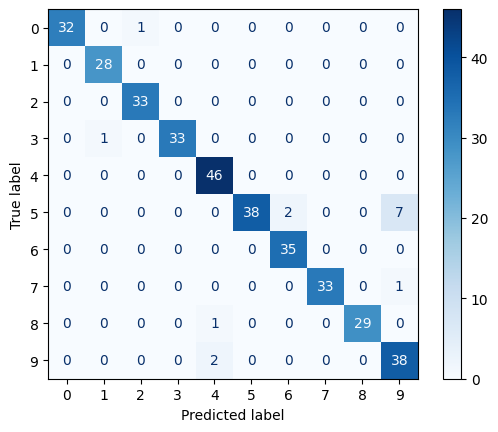

In [8]:
# ✅ 8. 분류 리포트 & Confusion Matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_true_classes, y_pred_classes, zero_division=0))
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, cmap='Blues')
plt.show()


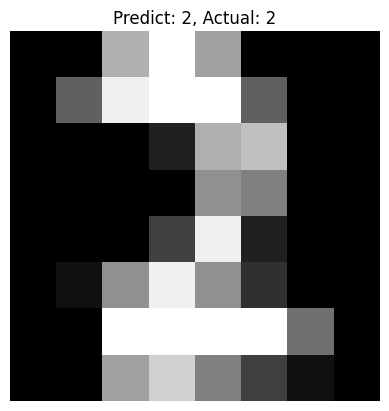

In [10]:
# ✅ 9. 예측 이미지 시각화
idx = 15  # 인덱스 조정 가능
plt.imshow(X_test_tensor[idx][0], cmap='gray')
plt.title(f"Predict: {y_pred_classes[idx].item()}, Actual: {y_true_classes[idx].item()}")
plt.axis('off')
plt.show()
